***1CDT***

Chunk 1 Metrics: Accuracy=0.977, F1 Score=0.9769975844565026, Precision=0.9770909600246519, Recall=0.977
Chunk 2 Metrics: Accuracy=0.998, F1 Score=0.998, Precision=0.998, Recall=0.998
Chunk 3 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 4 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 5 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 6 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 7 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 8 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 9 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 10 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 11 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 12 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 13 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 14 Metrics: Accuracy=1.0,

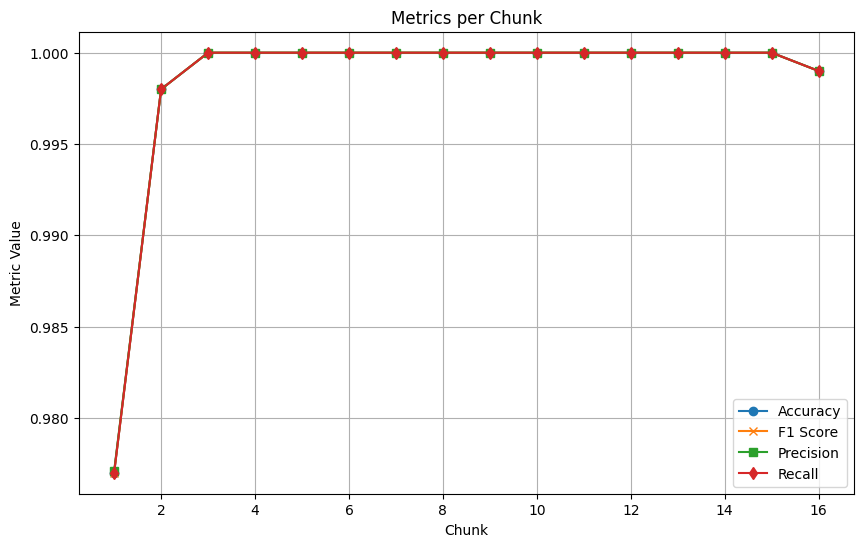

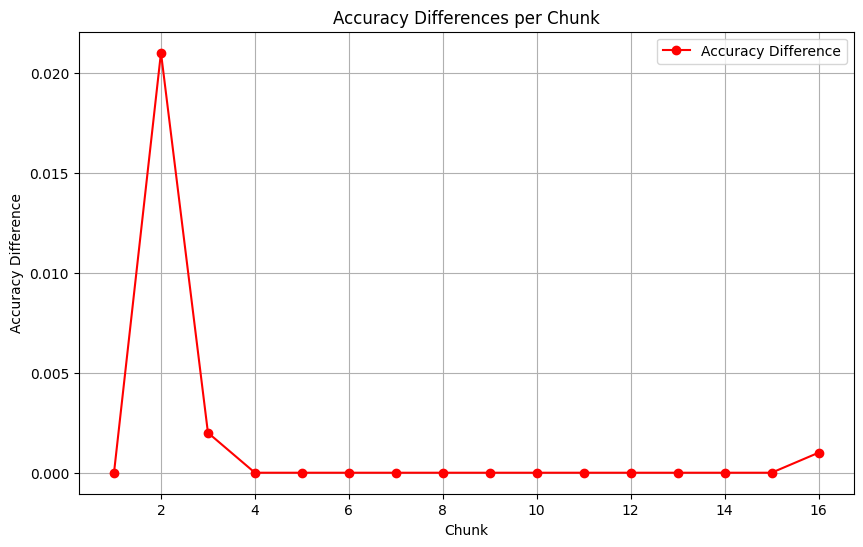

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './1CDT.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 1000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/1CDT_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/1CDT_d=2_summary_metrics.csv', index=False)


***2CDT***

Chunk 1 Metrics: Accuracy=0.947, F1 Score=0.946961542657375, Precision=0.9481101371599584, Recall=0.947
Chunk 2 Metrics: Accuracy=0.94, F1 Score=0.939984877035899, Precision=0.9405794733807418, Recall=0.94
Chunk 3 Metrics: Accuracy=0.939, F1 Score=0.9390000610000611, Precision=0.939002, Recall=0.939
Chunk 4 Metrics: Accuracy=0.946, F1 Score=0.9459987039792636, Precision=0.9460655265526552, Recall=0.946
Chunk 5 Metrics: Accuracy=0.942, F1 Score=0.9419965198747154, Precision=0.942181486460534, Recall=0.942
Chunk 6 Metrics: Accuracy=0.941, F1 Score=0.9409954564502304, Precision=0.9410831589434977, Recall=0.941
Chunk 7 Metrics: Accuracy=0.932, F1 Score=0.9319956468856028, Precision=0.9320211284513806, Recall=0.932
Chunk 8 Metrics: Accuracy=0.93, F1 Score=0.9299980396157647, Precision=0.9300035209013509, Recall=0.93
Chunk 9 Metrics: Accuracy=0.933, F1 Score=0.9329976548850893, Precision=0.9330419660431103, Recall=0.933
Chunk 10 Metrics: Accuracy=0.931, F1 Score=0.9309997929997931, Precision

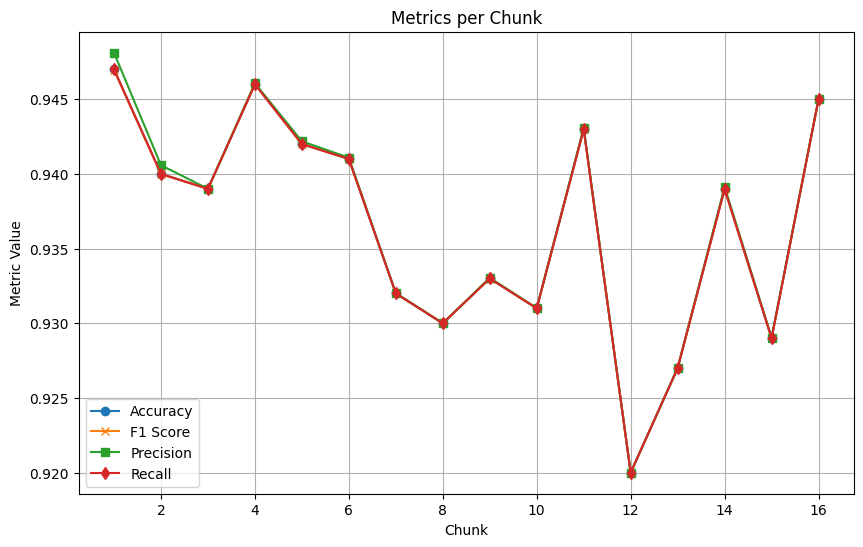

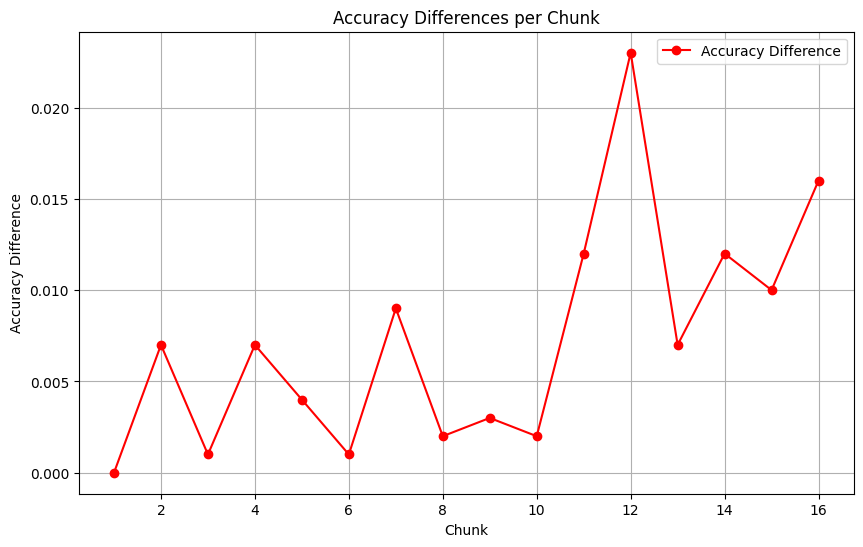

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

# Function to upload and load the dataset
file_path = './2CDT.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 1000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/2CDT_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/2CDT_d=2_summary_metrics.csv', index=False)

***1CHT***

Chunk 1 Metrics: Accuracy=0.934, F1 Score=0.934000792003168, Precision=0.9340688331013296, Recall=0.934
Chunk 2 Metrics: Accuracy=0.986, F1 Score=0.9859993279032181, Precision=0.9860302157352282, Recall=0.986
Chunk 3 Metrics: Accuracy=0.999, F1 Score=0.9990000030000269, Precision=0.999002004008016, Recall=0.999
Chunk 4 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 5 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 6 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 7 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 8 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 9 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 10 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 11 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 12 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 13 Metrics: Accuracy=1.0, F1 Score=1.0,

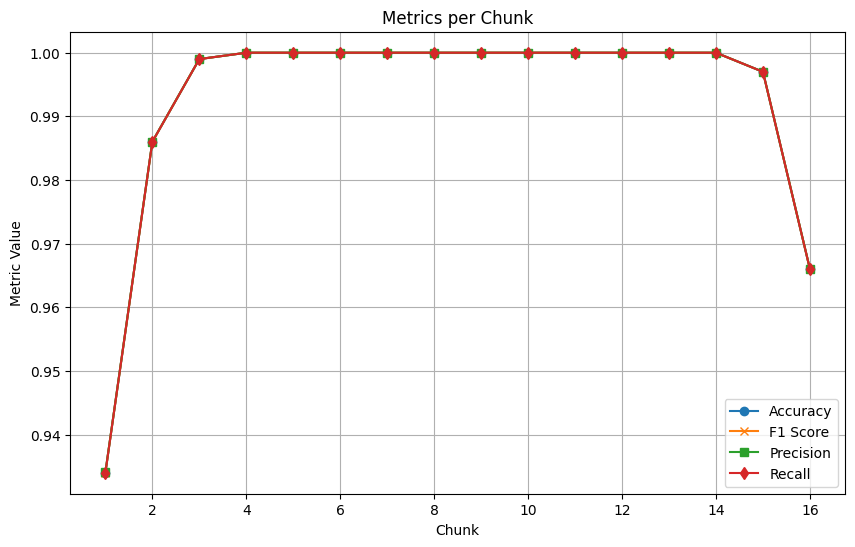

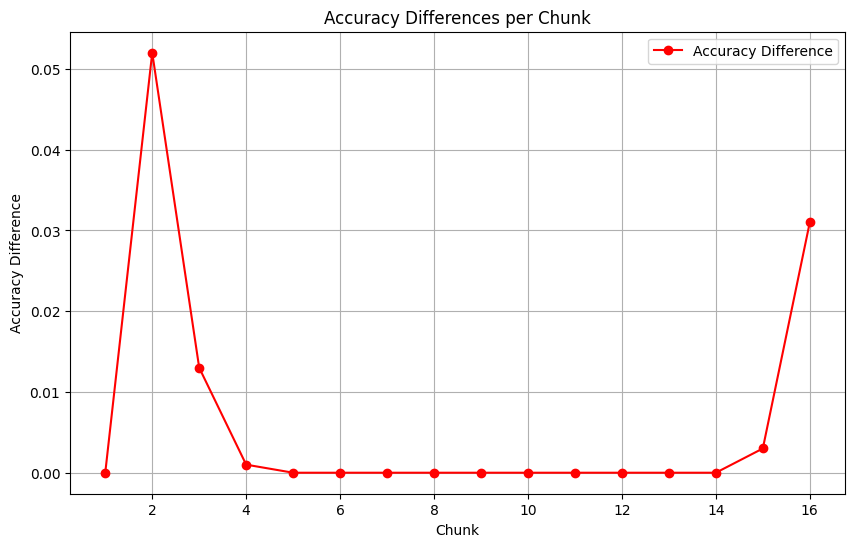

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './1CHT.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 1000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/1CHT_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/1CHT_d=2_summary_metrics.csv', index=False)

***2CHT***

Chunk 1 Metrics: Accuracy=0.863, F1 Score=0.8629211757348343, Precision=0.863757248701007, Recall=0.863
Chunk 2 Metrics: Accuracy=0.876, F1 Score=0.8759722168875232, Precision=0.8762880992893604, Recall=0.876
Chunk 3 Metrics: Accuracy=0.888, F1 Score=0.888, Precision=0.888, Recall=0.888
Chunk 4 Metrics: Accuracy=0.887, F1 Score=0.8870071195766857, Precision=0.8871011644046576, Recall=0.887
Chunk 5 Metrics: Accuracy=0.895, F1 Score=0.8949904433849319, Precision=0.8950686274509804, Recall=0.895
Chunk 6 Metrics: Accuracy=0.873, F1 Score=0.8730006350158753, Precision=0.8730030160482568, Recall=0.873
Chunk 7 Metrics: Accuracy=0.884, F1 Score=0.8840027844009537, Precision=0.8840126412641264, Recall=0.884
Chunk 8 Metrics: Accuracy=0.883, F1 Score=0.8829490621612777, Precision=0.8832961333140961, Recall=0.883
Chunk 9 Metrics: Accuracy=0.872, F1 Score=0.8720020480327685, Precision=0.872032, Recall=0.872
Chunk 10 Metrics: Accuracy=0.881, F1 Score=0.8810017850160651, Precision=0.8810476201904808,

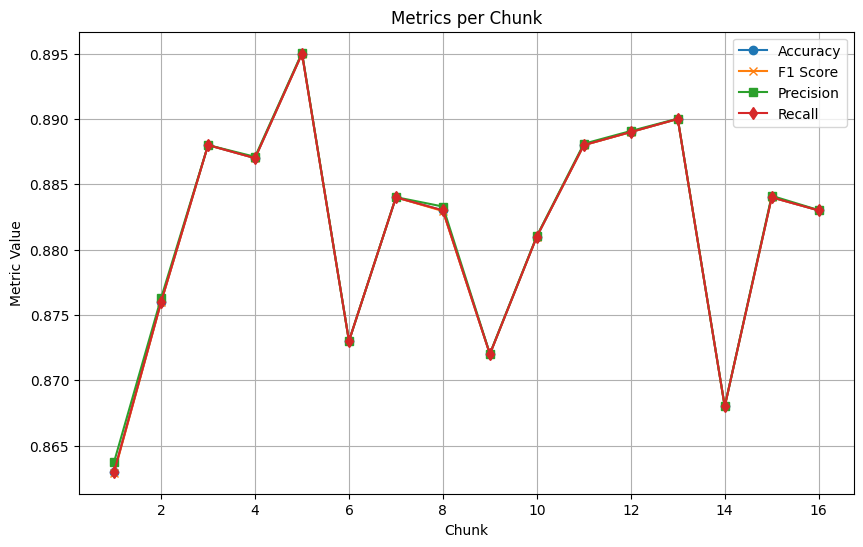

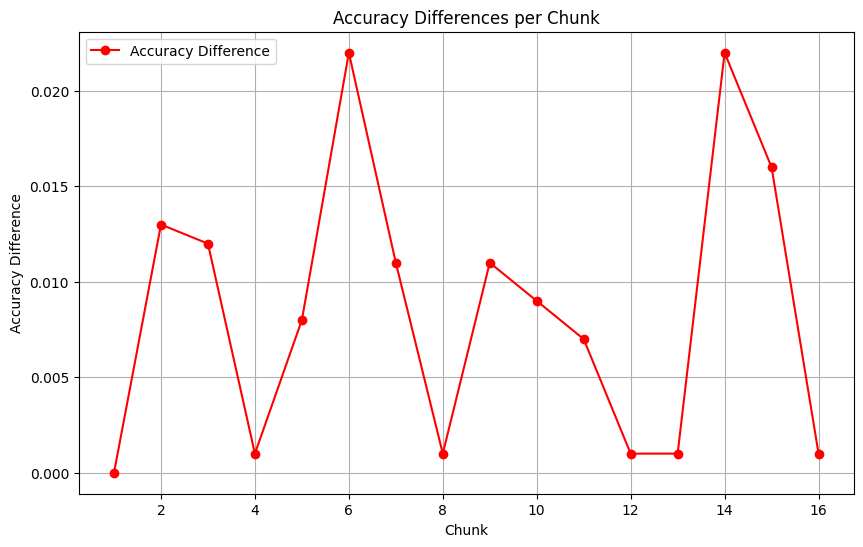

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './2CHT.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 1000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})
# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/2CHT_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/2CHT_d=2_summary_metrics.csv', index=False)

 ***4CR***

Chunk 1 Metrics: Accuracy=0.9999, F1 Score=0.999899999996, Precision=0.9999000399840065, Recall=0.9999
Chunk 2 Metrics: Accuracy=0.9996, F1 Score=0.999599999984, Precision=0.9996000799360129, Recall=0.9996
Chunk 3 Metrics: Accuracy=0.9991, F1 Score=0.9991000199560103, Precision=0.9991001597761408, Recall=0.9991
Chunk 4 Metrics: Accuracy=0.9997, F1 Score=0.999699999996, Precision=0.9997000399840065, Recall=0.9997
Chunk 5 Metrics: Accuracy=0.9994, F1 Score=0.999399999784, Precision=0.9994007191370354, Recall=0.9994
Chunk 6 Metrics: Accuracy=0.9996, F1 Score=0.9995999999760048, Precision=0.9996001198560958, Recall=0.9996
Chunk 7 Metrics: Accuracy=0.9998, F1 Score=0.999799999968, Precision=0.9998001598721022, Recall=0.9998
Chunk 8 Metrics: Accuracy=0.9996, F1 Score=0.9995999999760048, Precision=0.9996001198560958, Recall=0.9996
Chunk 9 Metrics: Accuracy=0.9995, F1 Score=0.9994999599599887, Precision=0.9995000398879678, Recall=0.9995
Chunk 10 Metrics: Accuracy=0.9996, F1 Score=0.99959997991

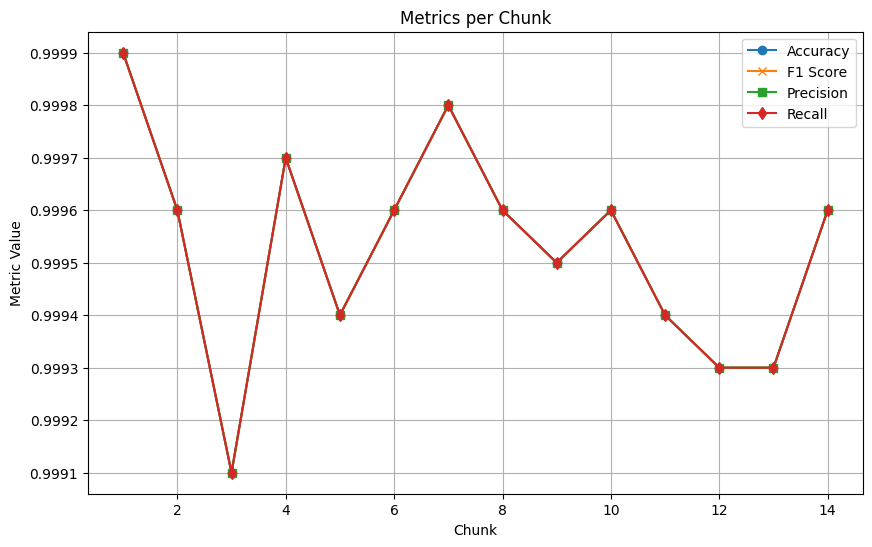

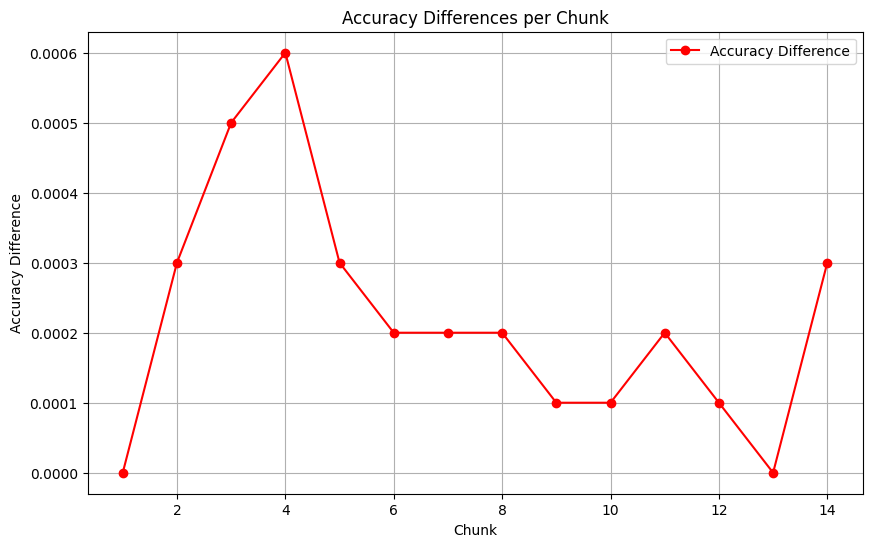

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './4CR.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 10000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes for the 4CR dataset on the first call
    if i == 0:
        unique_classes = np.unique([1, 2, 3, 4])

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})
# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/4CR_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/4CR_d=2_summary_metrics.csv', index=False)

***4CRE-V1***

Chunk 1 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 2 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 3 Metrics: Accuracy=0.994, F1 Score=0.9939997804686054, Precision=0.9940508463769964, Recall=0.994
Chunk 4 Metrics: Accuracy=0.988, F1 Score=0.9880116898551358, Precision=0.9880663433515622, Recall=0.988
Chunk 5 Metrics: Accuracy=0.995, F1 Score=0.99499993199896, Precision=0.9950197290714254, Recall=0.995
Chunk 6 Metrics: Accuracy=0.996, F1 Score=0.996001992007968, Precision=0.99600796812749, Recall=0.996
Chunk 7 Metrics: Accuracy=0.996, F1 Score=0.996, Precision=0.996, Recall=0.996
Chunk 8 Metrics: Accuracy=0.998, F1 Score=0.9979999919999679, Precision=0.9980079681274902, Recall=0.998
Chunk 9 Metrics: Accuracy=0.994, F1 Score=0.9939999679994881, Precision=0.994015873015873, Recall=0.994
Chunk 10 Metrics: Accuracy=0.992, F1 Score=0.9919999519034222, Precision=0.9920118558025961, Recall=0.992
Chunk 11 Metrics: Accuracy=0.998, F1 Score=0.9979

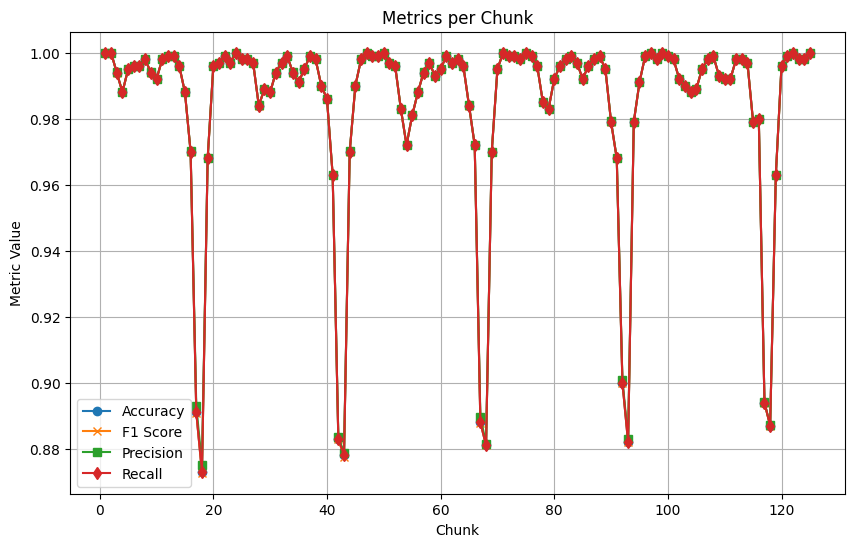

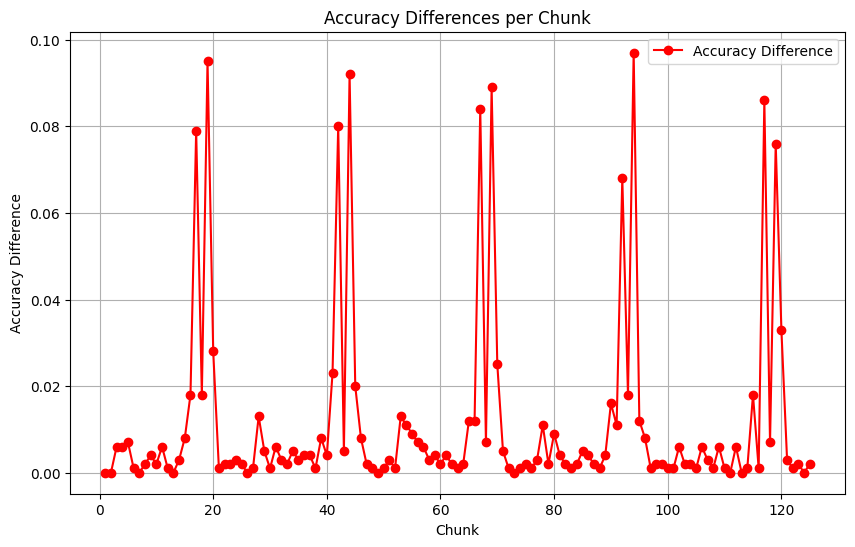

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './4CRE-V1.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 1000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes for the 4CR dataset on the first call
    if i == 0:
        unique_classes = np.unique([1, 2, 3, 4])

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/4CREV1_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/4CREV1_d=2_summary_metrics.csv', index=False)

***4CRE-V2***

Chunk 1 Metrics: Accuracy=0.9523333333333334, F1 Score=0.9523304750806508, Precision=0.9523311255058441, Recall=0.9523333333333334
Chunk 2 Metrics: Accuracy=0.842, F1 Score=0.8419299483090531, Precision=0.8422224936134938, Recall=0.842
Chunk 3 Metrics: Accuracy=0.9328333333333333, F1 Score=0.9328002449286154, Precision=0.9329209883056957, Recall=0.9328333333333333
Chunk 4 Metrics: Accuracy=0.9465, F1 Score=0.9464848605030951, Precision=0.9464833812169887, Recall=0.9465
Chunk 5 Metrics: Accuracy=0.9551666666666667, F1 Score=0.9551851515722765, Precision=0.9552165025715015, Recall=0.9551666666666667
Chunk 6 Metrics: Accuracy=0.9516666666666667, F1 Score=0.951663633503514, Precision=0.9516740099436587, Recall=0.9516666666666667
Chunk 7 Metrics: Accuracy=0.7461666666666666, F1 Score=0.7459813950598391, Precision=0.7479574270728143, Recall=0.7461666666666666
Chunk 8 Metrics: Accuracy=0.8005, F1 Score=0.800483231582625, Precision=0.8007057802946477, Recall=0.8005
Chunk 9 Metrics: Accuracy=0.

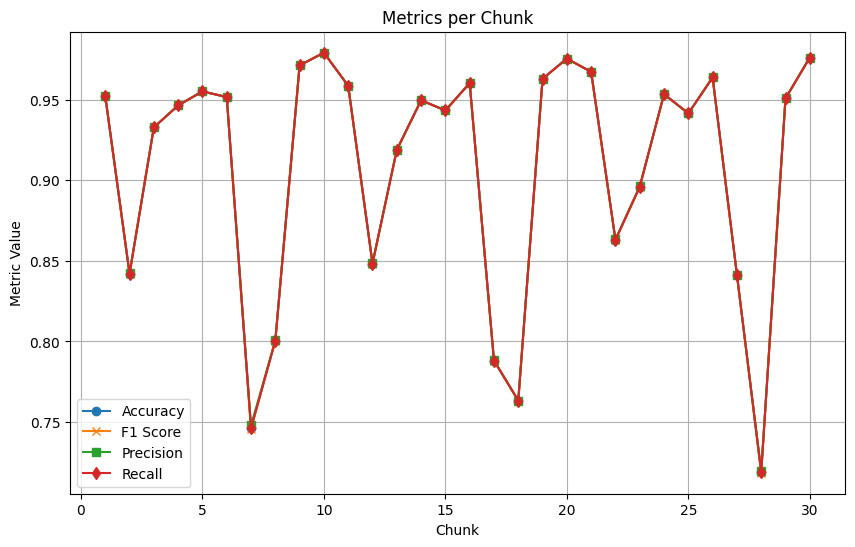

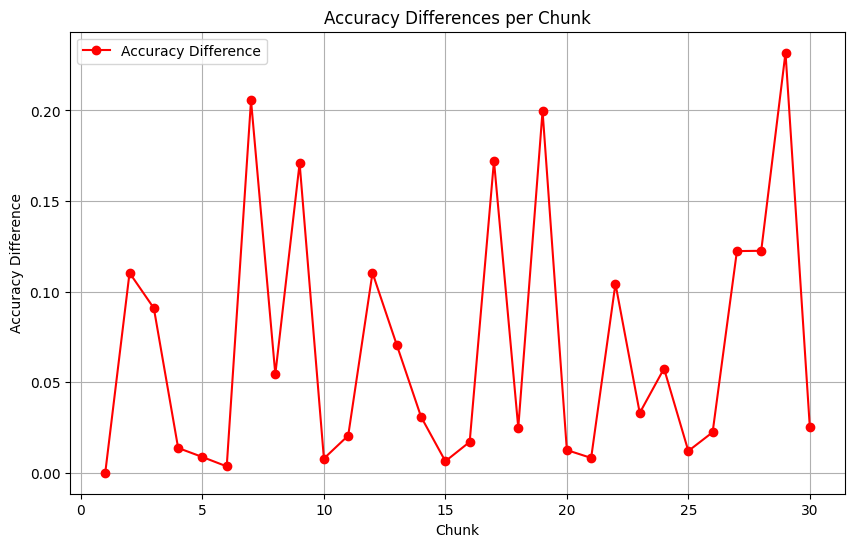

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './4CRE-V2.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 6000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes for the 4CR dataset on the first call
    if i == 0:
        unique_classes = np.unique([1, 2, 3, 4])

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})


# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/4CREV2_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/4CREV2_d=2_summary_metrics.csv', index=False)

***5CVT***

Chunk 1 Metrics: Accuracy=0.934, F1 Score=0.9340802546607714, Precision=0.9346700596730716, Recall=0.934
Chunk 2 Metrics: Accuracy=0.902, F1 Score=0.9026731633146727, Precision=0.9052195057140086, Recall=0.902
Chunk 3 Metrics: Accuracy=0.86, F1 Score=0.8613536410754107, Precision=0.8651456030047197, Recall=0.86
Chunk 4 Metrics: Accuracy=0.908, F1 Score=0.9081998728315709, Precision=0.9086828060190343, Recall=0.908
Chunk 5 Metrics: Accuracy=0.934, F1 Score=0.934445347122519, Precision=0.9366280146973789, Recall=0.934
Chunk 6 Metrics: Accuracy=0.912, F1 Score=0.9126828628948519, Precision=0.9144998001095562, Recall=0.912
Chunk 7 Metrics: Accuracy=0.922, F1 Score=0.9217318772511195, Precision=0.9218719422251943, Recall=0.922
Chunk 8 Metrics: Accuracy=0.916, F1 Score=0.9163873290648084, Precision=0.9176116091954023, Recall=0.916
Chunk 9 Metrics: Accuracy=0.902, F1 Score=0.9026298665382504, Precision=0.9048678689906445, Recall=0.902
Chunk 10 Metrics: Accuracy=0.93, F1 Score=0.93048689637815

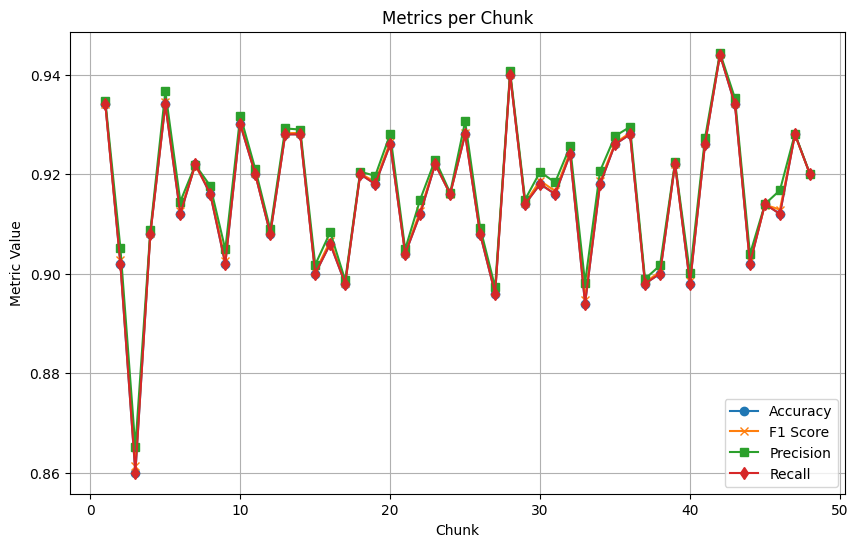

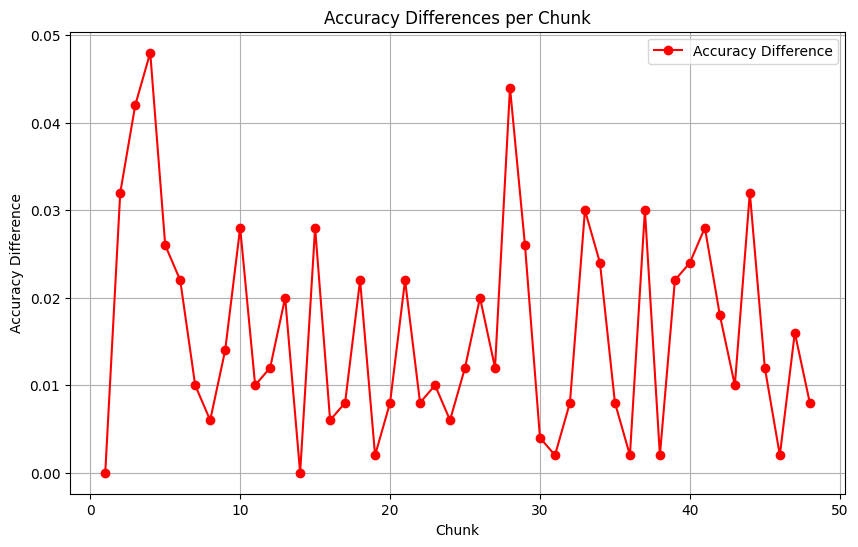

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './5CVT.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 500  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes for the 4CR dataset on the first call
    if i == 0:
        unique_classes = np.unique([1, 2, 3, 4 , 5])

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})


# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/5CVT_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/5CVT_d=2_summary_metrics.csv', index=False)

***1CSurr***

Chunk 1 Metrics: Accuracy=0.983, F1 Score=0.9830648880138266, Precision=0.9833905695007461, Recall=0.983
Chunk 2 Metrics: Accuracy=0.987, F1 Score=0.9870118985189551, Precision=0.9870430078160561, Recall=0.987
Chunk 3 Metrics: Accuracy=0.985, F1 Score=0.9850246266468555, Precision=0.9851030031831377, Recall=0.985
Chunk 4 Metrics: Accuracy=0.99, F1 Score=0.9900109581535512, Precision=0.9900556969810869, Recall=0.99
Chunk 5 Metrics: Accuracy=0.985, F1 Score=0.98501316160115, Precision=0.9850453793246109, Recall=0.985
Chunk 6 Metrics: Accuracy=0.988, F1 Score=0.9880117694805195, Precision=0.9880568429224822, Recall=0.988
Chunk 7 Metrics: Accuracy=0.978, F1 Score=0.9779859544174494, Precision=0.9779804370575023, Recall=0.978
Chunk 8 Metrics: Accuracy=0.982, F1 Score=0.9820565587066943, Precision=0.9824116270507932, Recall=0.982
Chunk 9 Metrics: Accuracy=0.985, F1 Score=0.9850394848034502, Precision=0.9852498937033745, Recall=0.985
Chunk 10 Metrics: Accuracy=0.988, F1 Score=0.98802536824877

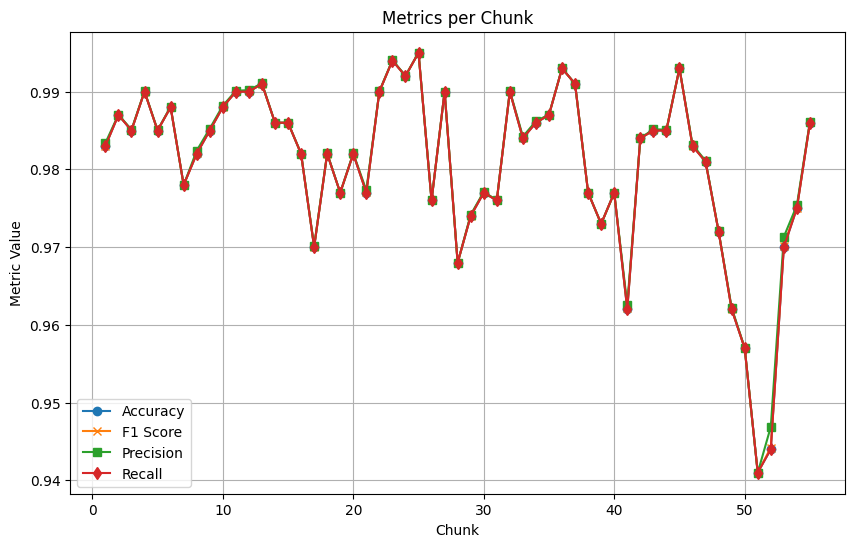

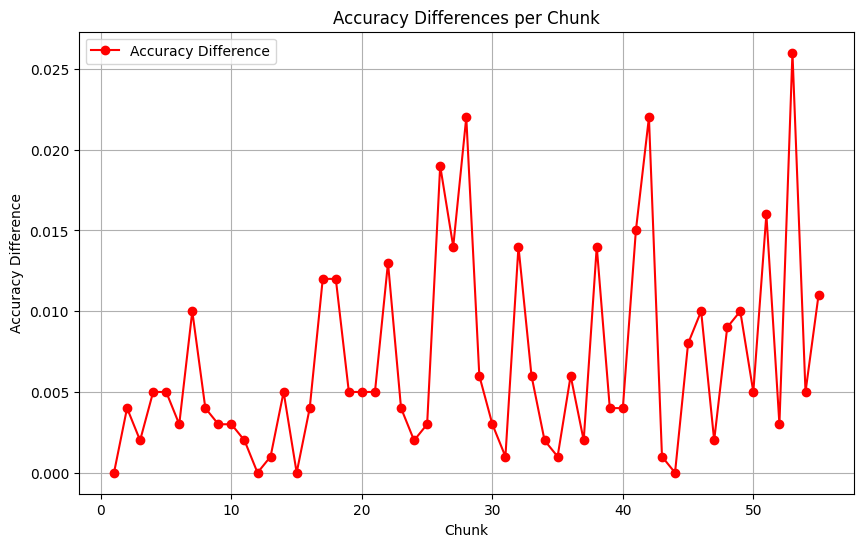

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './1CSurr.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.05 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 1000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/1CUsrr_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/1CUsrr_d=2_summary_metrics.csv', index=False)

***4CE1CF***

Chunk 1 Metrics: Accuracy=0.9655, F1 Score=0.9657634104929846, Precision=0.9663158819835056, Recall=0.9655
Chunk 2 Metrics: Accuracy=0.9757, F1 Score=0.9758250094887786, Precision=0.976061290054326, Recall=0.9757
Chunk 3 Metrics: Accuracy=0.9808, F1 Score=0.9809072379719284, Precision=0.9811549397169059, Recall=0.9808
Chunk 4 Metrics: Accuracy=0.9796, F1 Score=0.9797427371354935, Precision=0.9800888413296736, Recall=0.9796
Chunk 5 Metrics: Accuracy=0.983, F1 Score=0.9831237381291196, Precision=0.9834721533514532, Recall=0.983
Chunk 6 Metrics: Accuracy=0.9838, F1 Score=0.9838859718193009, Precision=0.984088170840549, Recall=0.9838
Chunk 7 Metrics: Accuracy=0.982, F1 Score=0.9821483133125294, Precision=0.9825580628267039, Recall=0.982
Chunk 8 Metrics: Accuracy=0.9837, F1 Score=0.9838119771713915, Precision=0.9841042828465179, Recall=0.9837
Chunk 9 Metrics: Accuracy=0.9848, F1 Score=0.9848931471145159, Precision=0.9851369865912062, Recall=0.9848
Chunk 10 Metrics: Accuracy=0.9851, F1 Score

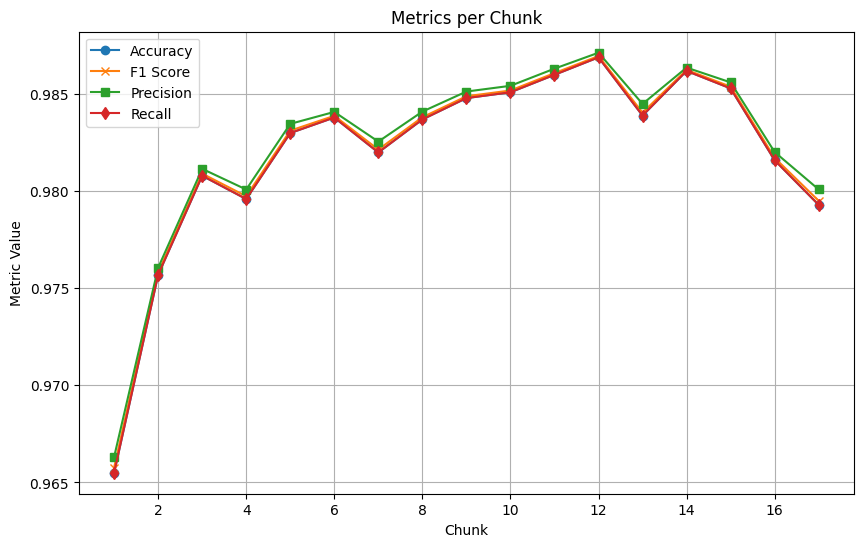

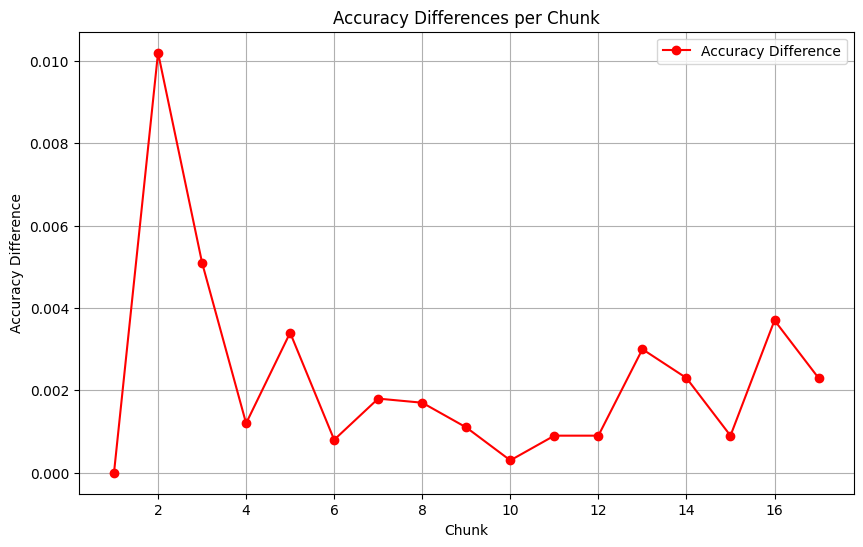

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './4CE1CF.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 10000  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes for the 4CR dataset on the first call
    if i == 0:
        unique_classes = np.unique([1, 2, 3, 4 , 5])

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})


# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/4CE1CF_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/4CE1CF_d=2_summary_metrics.csv', index=False)

***FG-2C-2D***

Chunk 1 Metrics: Accuracy=0.9705, F1 Score=0.970590996892966, Precision=0.9707373510038646, Recall=0.9705
Chunk 2 Metrics: Accuracy=0.9716, F1 Score=0.971464336140607, Precision=0.9714554419383423, Recall=0.9716
Chunk 3 Metrics: Accuracy=0.9696, F1 Score=0.9696760442054634, Precision=0.9697882985376498, Recall=0.9696
Chunk 4 Metrics: Accuracy=0.9714, F1 Score=0.9714863724511544, Precision=0.9716258672463169, Recall=0.9714
Chunk 5 Metrics: Accuracy=0.9762, F1 Score=0.9763024421548775, Precision=0.976514606793878, Recall=0.9762
Chunk 6 Metrics: Accuracy=0.9765, F1 Score=0.9764509287634563, Precision=0.9764266790018028, Recall=0.9765
Chunk 7 Metrics: Accuracy=0.9786, F1 Score=0.978645169047439, Precision=0.9787164572000091, Recall=0.9786
Chunk 8 Metrics: Accuracy=0.9692, F1 Score=0.969187655334342, Precision=0.9691762227747873, Recall=0.9692
Chunk 9 Metrics: Accuracy=0.9464, F1 Score=0.94560327180405, Precision=0.9459155330107384, Recall=0.9464
Chunk 10 Metrics: Accuracy=0.9201, F1 Score=

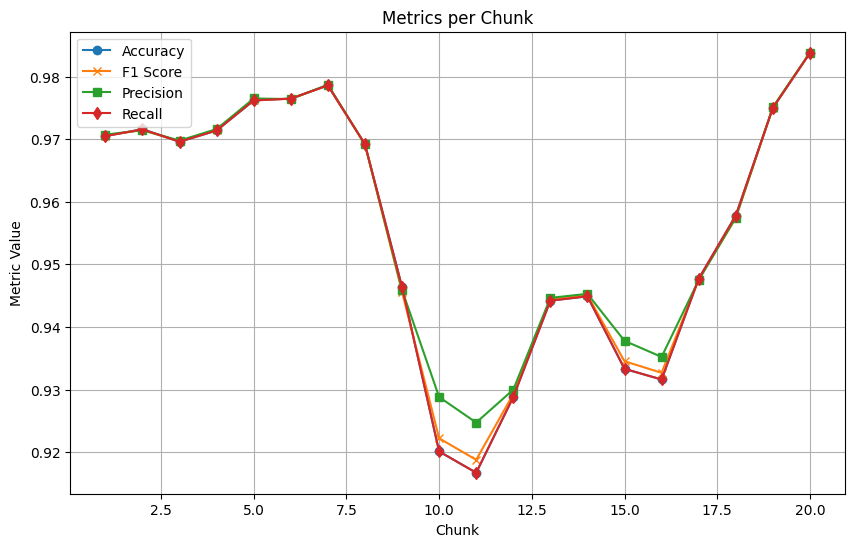

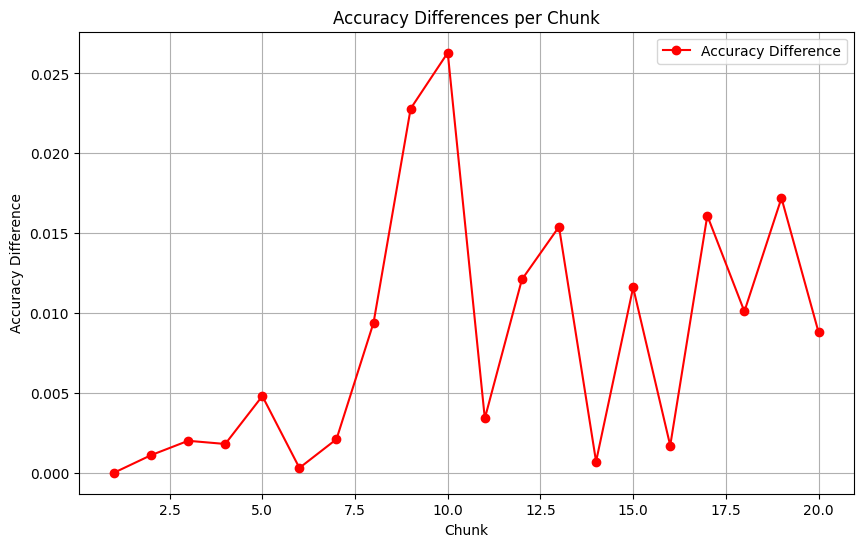

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './FG_2C_2D.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values


# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 10000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/FG2C2D_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/FG2C2D_d=2_summary_metrics.csv', index=False)

***UG-2C-2D***

Chunk 1 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 2 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 3 Metrics: Accuracy=0.998, F1 Score=0.998, Precision=0.998, Recall=0.998
Chunk 4 Metrics: Accuracy=0.997, F1 Score=0.996999996999997, Precision=0.997001988007952, Recall=0.997
Chunk 5 Metrics: Accuracy=0.995, F1 Score=0.9949999949999949, Precision=0.99500198000792, Recall=0.995
Chunk 6 Metrics: Accuracy=0.989, F1 Score=0.9889999009991091, Precision=0.9890176046337669, Recall=0.989
Chunk 7 Metrics: Accuracy=0.996, F1 Score=0.995999935998976, Precision=0.996031746031746, Recall=0.996
Chunk 8 Metrics: Accuracy=0.987, F1 Score=0.9869999869999869, Precision=0.987001948007792, Recall=0.987
Chunk 9 Metrics: Accuracy=0.988, F1 Score=0.988, Precision=0.988, Recall=0.988
Chunk 10 Metrics: Accuracy=0.972, F1 Score=0.9719995519928318, Precision=0.9720302099334358, Recall=0.972
Chunk 11 Metrics: Accuracy=0.979, F1 Score=0.978999978999979, Precision=0.97

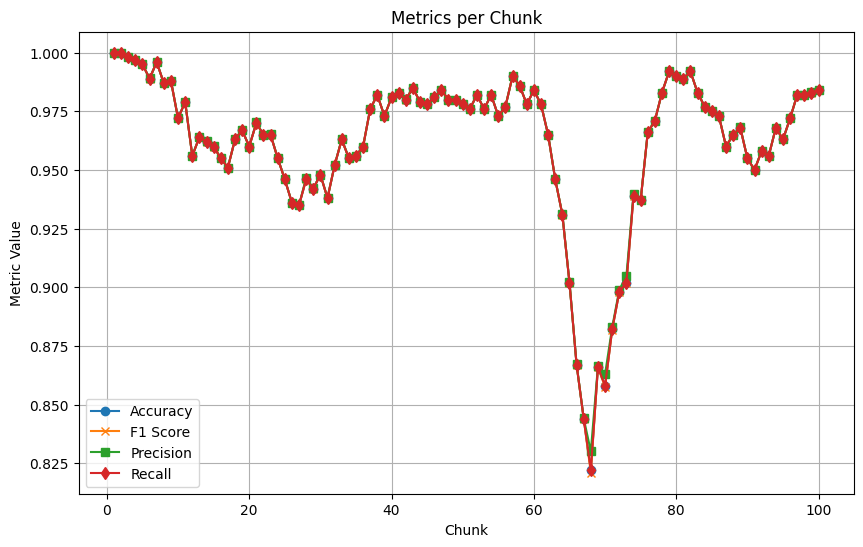

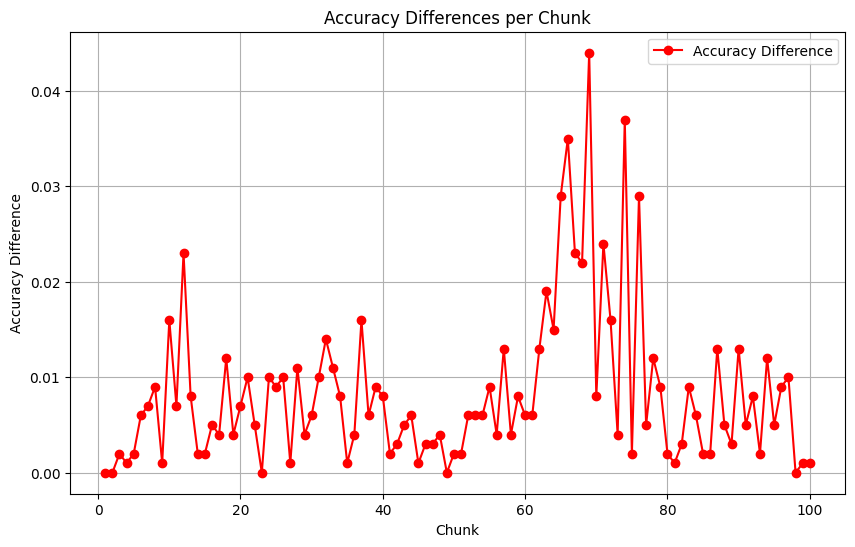

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './UG_2C_2D.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.05, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 1000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})
# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/UG2C2D_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/UG2C2D_d=2_summary_metrics.csv', index=False)

***UG-2C-3D***

Chunk 1 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 2 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 3 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 4 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 5 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 6 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 7 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 8 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 9 Metrics: Accuracy=0.999, F1 Score=0.998999998999999, Precision=0.999001996007984, Recall=0.999
Chunk 10 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 11 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 12 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 13 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 14 Metrics: Accuracy=1.0, F1 Score=

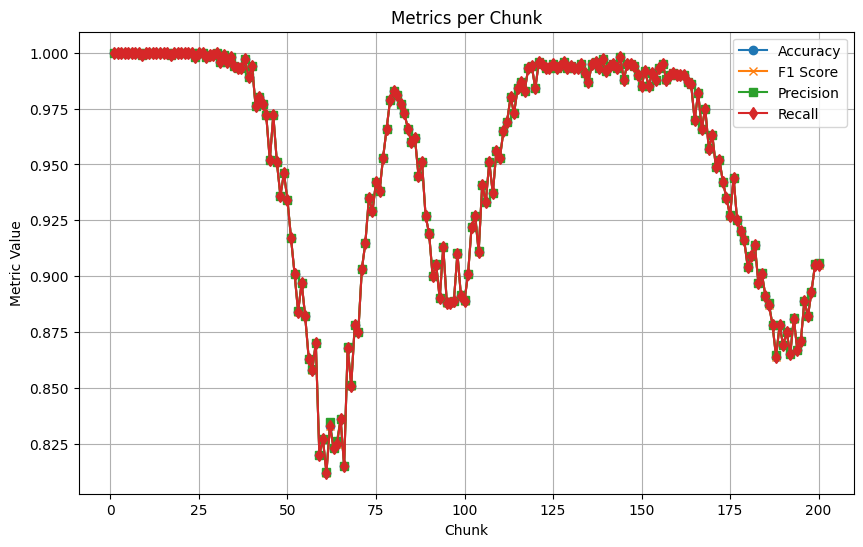

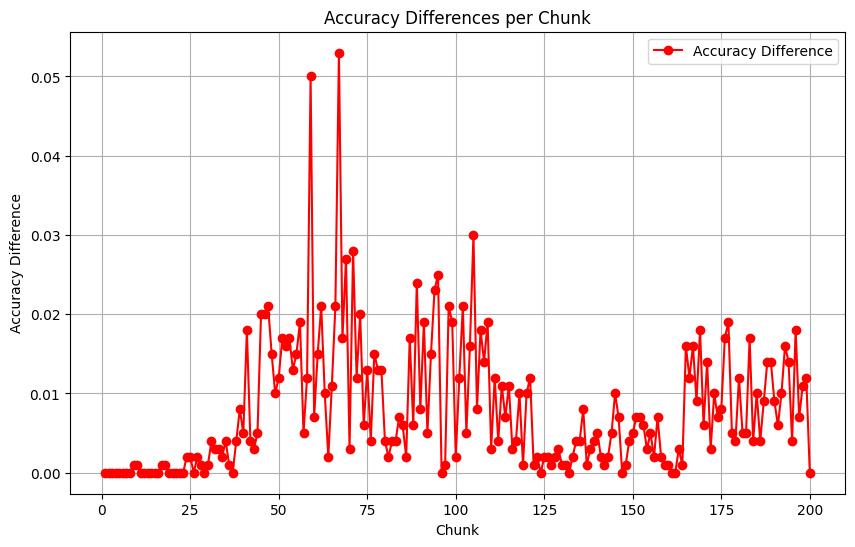

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './UG_2C_3D.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2','Column3', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 1000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/UG2C3D_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/UG2C3D_d=2_summary_metrics.csv', index=False)

***UG-2C-5D***

Chunk 1 Metrics: Accuracy=0.999, F1 Score=0.9989999829950856, Precision=0.9990019646365422, Recall=0.999
Chunk 2 Metrics: Accuracy=0.999, F1 Score=0.9990000150033759, Precision=0.9990020283975659, Recall=0.999
Chunk 3 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 4 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 5 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 6 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 7 Metrics: Accuracy=1.0, F1 Score=1.0, Precision=1.0, Recall=1.0
Chunk 8 Metrics: Accuracy=0.999, F1 Score=0.999000009000729, Precision=0.9990020161290322, Recall=0.999
Chunk 9 Metrics: Accuracy=0.998, F1 Score=0.9980000640163883, Precision=0.9980081135902638, Recall=0.998
Chunk 10 Metrics: Accuracy=0.996, F1 Score=0.996, Precision=0.996, Recall=0.996
Chunk 11 Metrics: Accuracy=0.998, F1 Score=0.998, Precision=0.998, Recall=0.998
Chunk 12 Metrics: Accuracy=0.997, F1 Score=0.9969999309634797, Pre

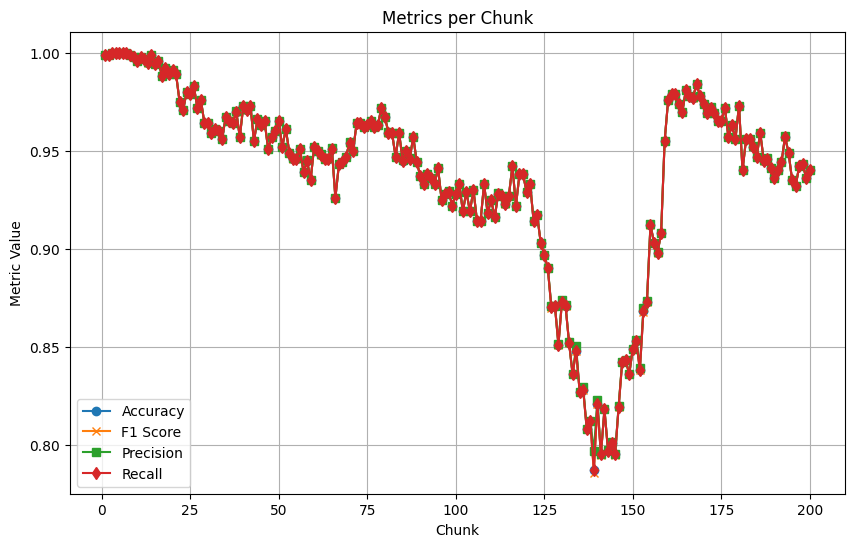

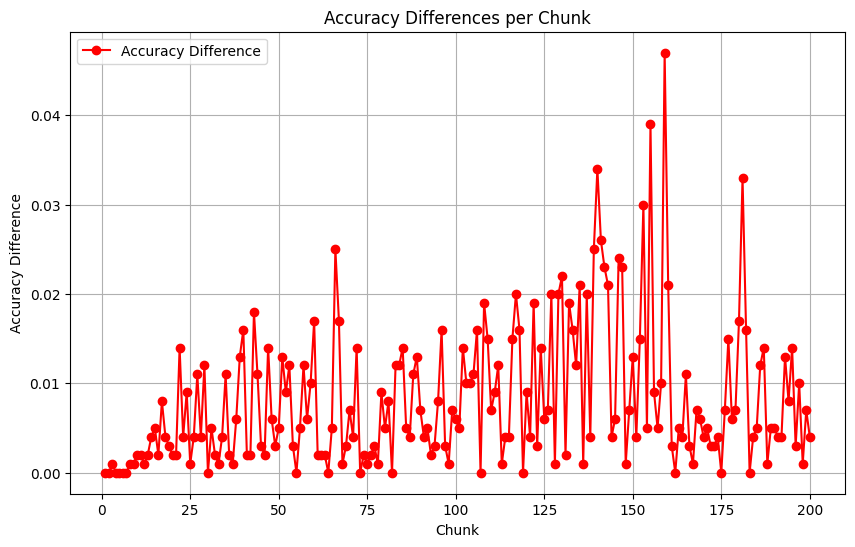

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './UG_2C_5D.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2','Column3','Column4','Column5','Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01 , warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 1000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/UG2C5D_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/UG2C5D_d=2_summary_metrics.csv', index=False)

***MG_2C_2D***

Chunk 1 Metrics: Accuracy=0.9982, F1 Score=0.9981999997119998, Precision=0.998200318848204, Recall=0.9982
Chunk 2 Metrics: Accuracy=0.9965, F1 Score=0.996499999965, Precision=0.9965000198600008, Recall=0.9965
Chunk 3 Metrics: Accuracy=0.9892, F1 Score=0.9891999961119986, Precision=0.9892007044490143, Recall=0.9892
Chunk 4 Metrics: Accuracy=0.9787, F1 Score=0.9786999384428222, Precision=0.978705533835971, Recall=0.9787
Chunk 5 Metrics: Accuracy=0.9562, F1 Score=0.956199299188787, Precision=0.9562291986687147, Recall=0.9562
Chunk 6 Metrics: Accuracy=0.9238, F1 Score=0.923786315070734, Precision=0.9241046088942924, Recall=0.9238
Chunk 7 Metrics: Accuracy=0.8896, F1 Score=0.8895846257632911, Precision=0.8898171125389998, Recall=0.8896
Chunk 8 Metrics: Accuracy=0.8714, F1 Score=0.8712665239827263, Precision=0.8729467444098958, Recall=0.8714
Chunk 9 Metrics: Accuracy=0.8554, F1 Score=0.8551952808802973, Precision=0.8574212313601911, Recall=0.8554
Chunk 10 Metrics: Accuracy=0.8445, F1 Score=0

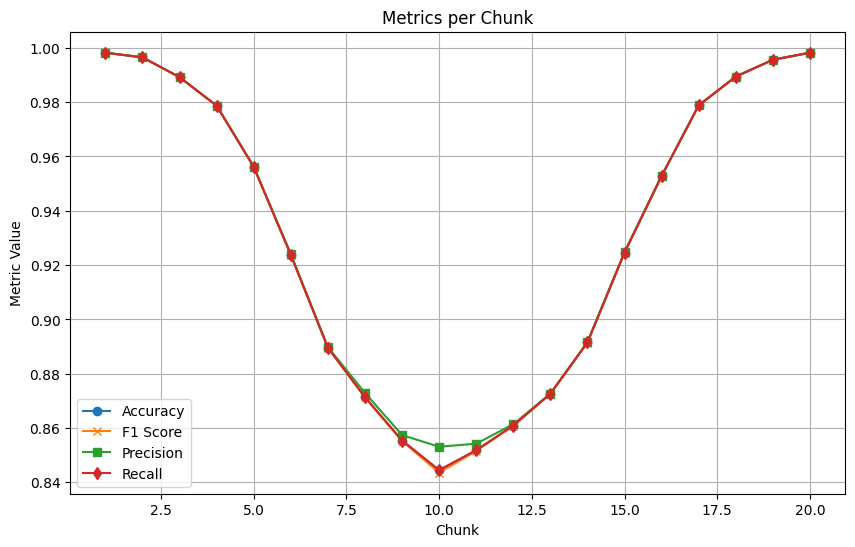

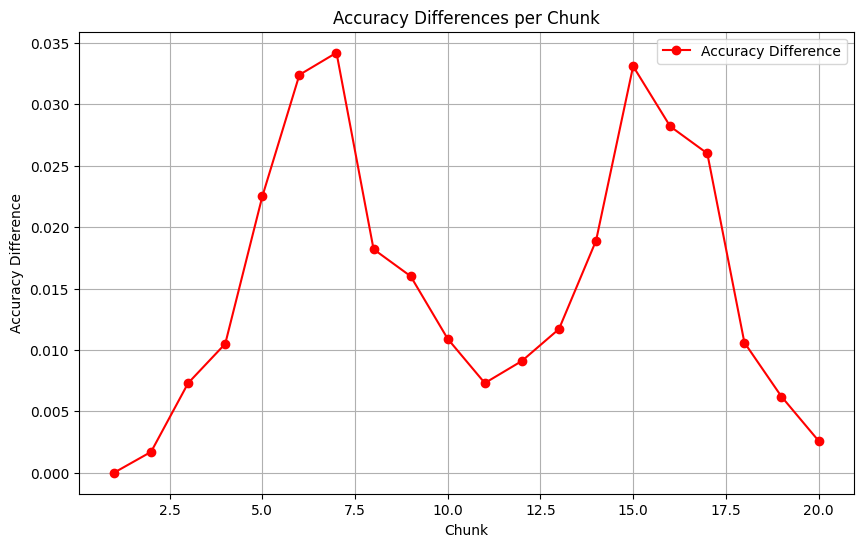

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './MG_2C_2D.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.05, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 10000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/MG2C2D_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/MG2C2D_d=2_summary_metrics.csv', index=False)

***GEARS-2C-2D***

Chunk 1 Metrics: Accuracy=0.9592, F1 Score=0.9591982226745797, Precision=0.9592800249515476, Recall=0.9592
Chunk 2 Metrics: Accuracy=0.9605, F1 Score=0.9604993991958618, Precision=0.9605280185246471, Recall=0.9605
Chunk 3 Metrics: Accuracy=0.9596, F1 Score=0.9595998044630536, Precision=0.9596088980282659, Recall=0.9596
Chunk 4 Metrics: Accuracy=0.9596, F1 Score=0.9595994166155759, Precision=0.9596265480294142, Recall=0.9596
Chunk 5 Metrics: Accuracy=0.962, F1 Score=0.9619997020776642, Precision=0.962014488774368, Recall=0.962
Chunk 6 Metrics: Accuracy=0.9574, F1 Score=0.9573993183890943, Precision=0.9574292754736303, Recall=0.9574
Chunk 7 Metrics: Accuracy=0.961, F1 Score=0.9609986879958642, Precision=0.9610620405081707, Recall=0.961
Chunk 8 Metrics: Accuracy=0.9631, F1 Score=0.9630999701109758, Precision=0.9631015004488614, Recall=0.9631
Chunk 9 Metrics: Accuracy=0.959, F1 Score=0.9589982139622003, Precision=0.9590799900974746, Recall=0.959
Chunk 10 Metrics: Accuracy=0.9593, F1 Score=

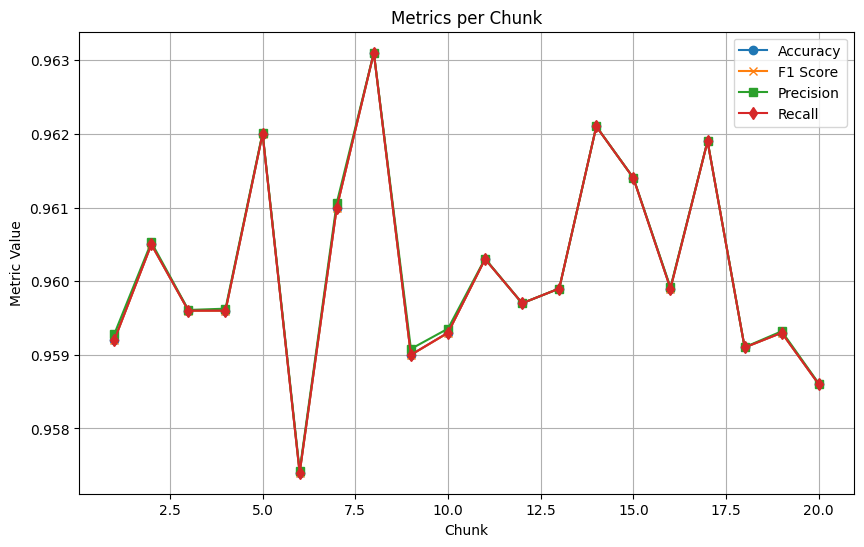

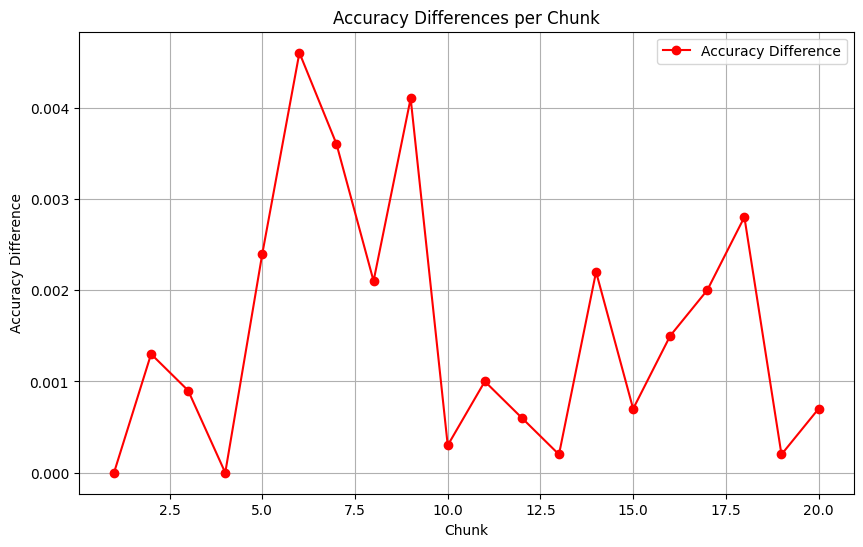

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './GEARS_2C_2D.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2', 'Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.01, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 10000 # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes on the first call
    if i == 0:
        unique_classes = np.unique(y_source)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/GEAR2C2D_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/GEAR2C2D_d=2_summary_metrics.csv', index=False)

**`Real-world Datasets`**

***Keystroke***

Chunk 1 Metrics: Accuracy=0.79, F1 Score=0.7823784297959334, Precision=0.7961426454370003, Recall=0.79
Chunk 2 Metrics: Accuracy=0.96, F1 Score=0.9592079653846772, Precision=0.963598901098901, Recall=0.96
Chunk 3 Metrics: Accuracy=0.86, F1 Score=0.8594914551186328, Precision=0.8886607142857144, Recall=0.86
Chunk 4 Metrics: Accuracy=0.97, F1 Score=0.9695252077917911, Precision=0.9718660968660968, Recall=0.97
Chunk 5 Metrics: Accuracy=0.91, F1 Score=0.9109514251304697, Precision=0.915064935064935, Recall=0.91
Chunk 6 Metrics: Accuracy=0.92, F1 Score=0.9209212531166312, Precision=0.9237001424501424, Recall=0.92
Chunk 7 Metrics: Accuracy=0.94, F1 Score=0.9404219938566443, Precision=0.9455172413793104, Recall=0.94
Chunk 8 Metrics: Accuracy=0.97, F1 Score=0.9697919167667066, Precision=0.9699679487179489, Recall=0.97
Chunk 9 Metrics: Accuracy=0.97, F1 Score=0.9699959983993597, Precision=0.9703846153846155, Recall=0.97
Chunk 10 Metrics: Accuracy=0.97, F1 Score=0.9699754901960784, Precision=0.9

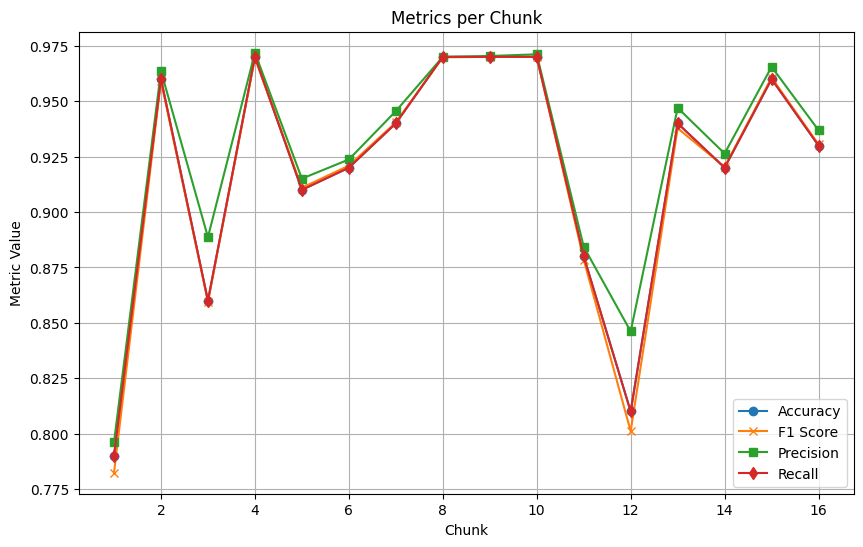

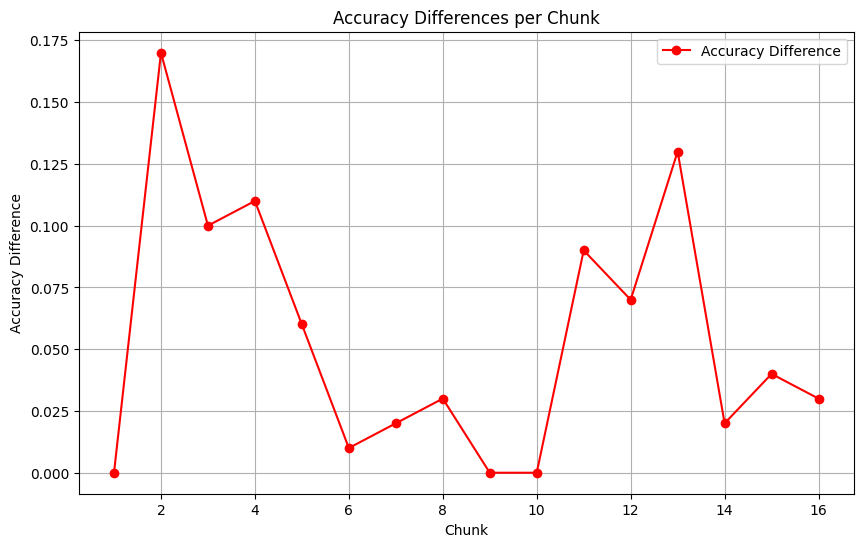

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt

file_path = './keystroke.txt'
df = pd.read_csv(file_path, delimiter=',', header=None, names=['Column1', 'Column2','Column3','Column4', 'Column5','Column6','Column7','Column8','Column9','Column10','Label'])
data = df.values

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 100  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Initialize unique classes for the 4CR dataset on the first call
    if i == 0:
        unique_classes = np.unique([1, 2, 3, 4])

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/Keystroke_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/Keystroke_d=2_summary_metrics.csv', index=False)

**Energy Efficiency**
 https://archive.ics.uci.edu/dataset/242/energy+efficiency

In [ ]:
''' The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The aim is to use the eight features to predict each of the two responses.
Specifically:
X1	Relative Compactness
X2	Surface Area
X3	Wall Area
X4	Roof Area
X5	Overall Height
X6	Orientation
X7	Glazing Area
X8	Glazing Area Distribution
y1	Heating Load
y2	Cooling Load

SyntaxError: incomplete input (<ipython-input-79-f5b6825162c3>, line 1)

 Prediction for Y1: Heating Load

     X1     X2     X3      X4   X5  X6   X7  X8     Y1  Y1_binned
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55        0.0
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55        0.0
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55        0.0
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55        0.0
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84        1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X1         768 non-null    float64
 1   X2         768 non-null    float64
 2   X3         768 non-null    float64
 3   X4         768 non-null    float64
 4   X5         768 non-null    float64
 5   X6         768 non-null    int64  
 6   X7         768 non-null    float64
 7   X8         768 non-null    int64  
 8   Y1         768 non-null    float64
 9   Y1_binned  768 non-null    float64
dtypes: float64(8),

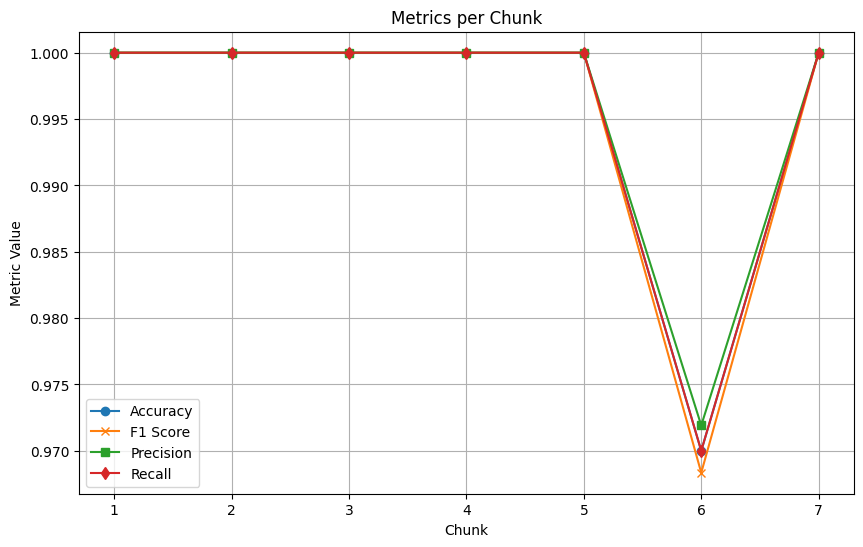

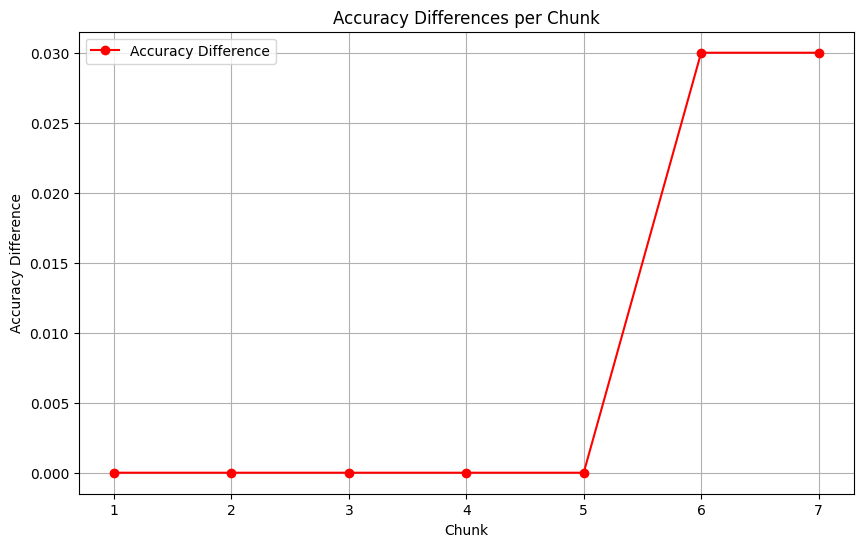

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

from google.colab import drive


# Function to load the dataset
def load_data():
    # Provide the full path to your dataset in Google Drive
    file_path = './ENB2012_data.xlsx'
    # Load the Excel file
    df = pd.read_excel(file_path)

    # Drop the 'Y2' column
    df = df.drop(columns=['Y2'])

    return df

# Load the dataset
df = load_data()

# Convert Y1 (continuous heating load) to a categorical variable using binning (for classification purposes)
# For example, bin Y1 into 3 categories (low, medium, high)
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
df['Y1_binned'] = discretizer.fit_transform(df[['Y1']])

# Prepare data by excluding the original 'Y1' and using 'Y1_binned' as labels
data = df.drop(columns=['Y1']).values  # Features
labels = df['Y1_binned'].values  # Categorical labels (binned)

# Combine features and labels into the data array for chunk processing
data = np.hstack((data, labels.reshape(-1, 1)))

# Preview the dataset to ensure proper loading and conversion
print(df.head())
print(df.info())

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 100  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Get unique classes from the entire dataset to avoid class mismatch
unique_classes = np.unique(labels)

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call to ensure all classes are handled
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

   # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/Y1_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/Y1_d=2_summary_metrics.csv', index=False)

Prediction for Y2: Cooling Load

     X1     X2     X3      X4   X5  X6   X7  X8     Y2  Y2_binned
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  21.33        0.0
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  21.33        0.0
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  21.33        0.0
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  21.33        0.0
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  28.28        1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X1         768 non-null    float64
 1   X2         768 non-null    float64
 2   X3         768 non-null    float64
 3   X4         768 non-null    float64
 4   X5         768 non-null    float64
 5   X6         768 non-null    int64  
 6   X7         768 non-null    float64
 7   X8         768 non-null    int64  
 8   Y2         768 non-null    float64
 9   Y2_binned  768 non-null    float64
dtypes: float64(8),

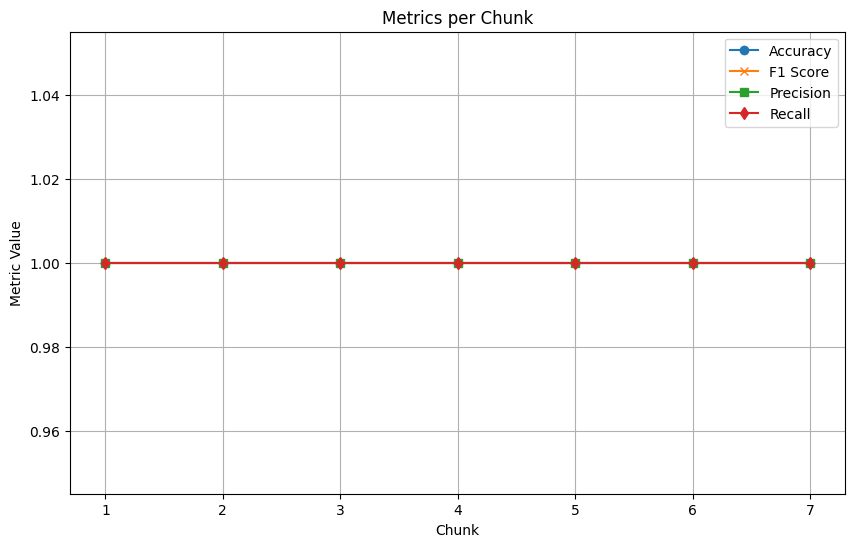

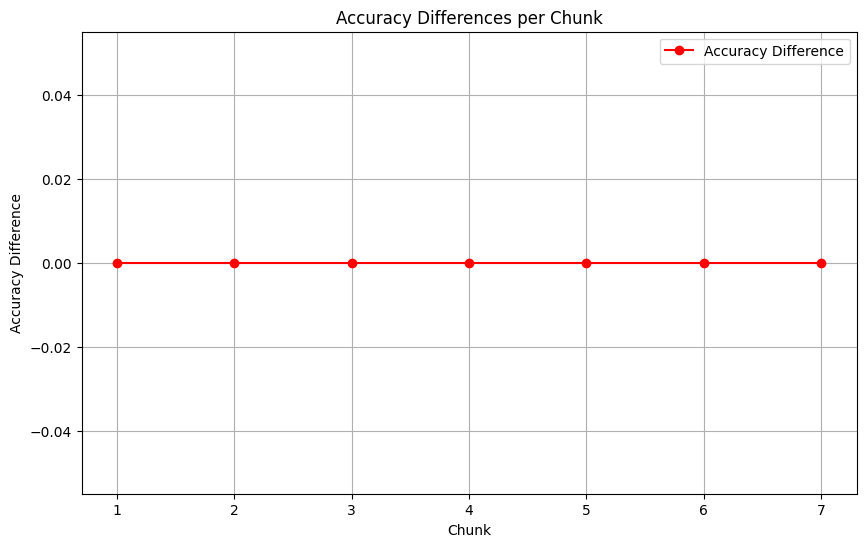

In [ ]:
# Incremental Drift-Adaptive Transfer Learning (IDATL)

# Importing necessary libraries
import numpy as np
import pandas as pd
import time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.base import clone
from scipy.stats import wasserstein_distance
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Function to load the dataset
def load_data():
    # Provide the full path to your dataset in Google Drive
    file_path = './ENB2012_data.xlsx'
    # Load the Excel file
    df = pd.read_excel(file_path)

    # Drop the 'Y1' column
    df = df.drop(columns=['Y1'])

    return df

# Load the dataset
df = load_data()

# Convert Y2 (continuous heating load) to a categorical variable using binning (for classification purposes)
# For example, bin Y2 into 3 categories (low, medium, high)
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
df['Y2_binned'] = discretizer.fit_transform(df[['Y2']])

# Prepare data by excluding the original 'Y2' and using 'Y2_binned' as labels
data = df.drop(columns=['Y2']).values  # Features
labels = df['Y2_binned'].values  # Categorical labels (binned)

# Combine features and labels into the data array for chunk processing
data = np.hstack((data, labels.reshape(-1, 1)))

# Preview the dataset to ensure proper loading and conversion
print(df.head())
print(df.info())

# Initialize components
sgd_model = SGDClassifier(loss='log_loss', learning_rate='adaptive', eta0=0.1, warm_start=True)
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

chunk_size = 100  # Adjust this based on your chunk size
num_chunks = len(data) // chunk_size

# Variables for concept drift detection and metrics tracking
previous_chunk_X, previous_chunk_y = None, None  # Store previous chunk for Wasserstein distance calculation
accuracies, f1_scores, precisions, recalls, accuracy_diffs = [], [], [], [], []

# Get unique classes from the entire dataset to avoid class mismatch
unique_classes = np.unique(labels)

# Start timing
start_time = time.time()

# Loop through the chunks of data
for i in range(num_chunks):
    # Extract the current chunk
    chunk = data[i * chunk_size:(i + 1) * chunk_size]
    X_source = chunk[:, :-1]  # Features
    y_source = chunk[:, -1]   # Labels

    # Apply scaling and polynomial feature transformation
    X_source_scaled = scaler.fit_transform(X_source)
    X_source_poly_scaled = poly.fit_transform(X_source_scaled)

    # Train the model using partial fit
    if i == 0:
        # Pass the classes parameter during the first call to ensure all classes are handled
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)
    else:
        sgd_model.partial_fit(X_source_poly_scaled, y_source)

    # Make predictions and calculate metrics
    y_pred = sgd_model.predict(X_source_poly_scaled)
    accuracy = accuracy_score(y_source, y_pred)
    f1 = f1_score(y_source, y_pred, average='weighted')
    precision = precision_score(y_source, y_pred, average='weighted')
    recall = recall_score(y_source, y_pred, average='weighted')

    accuracies.append(accuracy)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Chunk {i+1} Metrics: Accuracy={accuracy}, F1 Score={f1}, Precision={precision}, Recall={recall}")

    # Drift detection and adaptive learning rate adjustment
if previous_chunk_X is not None:
    wd_X = wasserstein_distance(previous_chunk_X.flatten(), X_source_poly_scaled.flatten())

    # Calculate adaptive threshold based on historical Wasserstein distances
    if i == 1:
        wd_history = [wd_X]  # Initialize history of Wasserstein distances
    else:
        wd_history.append(wd_X)

    mean_wd = np.mean(wd_history)
    std_wd = np.std(wd_history)
    adaptive_threshold = mean_wd + 0.5 * std_wd  # Example adaptive threshold

    # Drift detection logic with dynamic threshold
    if wd_X > adaptive_threshold:
        print(f"Concept drift detected in chunk {i+1}. Wasserstein distance: {wd_X} (features)")

        # Dynamic adjustment of learning rate based on the magnitude of drift
        if 0.0 < wd_X < 0.1:
            sgd_model.eta0 *= 0.8
        elif 0.1 <= wd_X < 0.2:
            sgd_model.eta0 *= 0.5
        elif wd_X >= 0.2:
            sgd_model.eta0 *= 0.2

        # Optionally, update the scaler with new data if feature drift is detected
        scaler.partial_fit(X_source)

        # Fine-tune the model with the adjusted learning rate
        sgd_model.partial_fit(X_source_poly_scaled, y_source, classes=unique_classes)

# End timing
end_time = time.time()
total_time = end_time - start_time

# Calculate the total absolute difference in accuracy
accuracy_diffs = np.abs(np.diff(accuracies))  # Differences in accuracy between consecutive chunks
n_taad = np.sum(accuracy_diffs) / (num_chunks - 1)

# Print final summary
print(f"Final Average Accuracy: {np.mean(accuracies)}")
print(f"Total time for processing: {total_time} seconds")
print(f"Normalized Total Absolute Accuracy Differences (N-TAAD): {n_taad}")

# Create a summary table with the metrics
metrics_df = pd.DataFrame({
    'Chunk': np.arange(1, num_chunks+1),
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Precision': precisions,
    'Recall': recalls
})

# Add the accuracy differences column (the first difference is set to 0 since there's no previous chunk for it)
metrics_df['Accuracy Difference'] = [0] + accuracy_diffs.tolist()

# Display the metrics table
print(metrics_df)

# Calculate min,mean, median, and number of chunks below mean/median
min_accuracy = metrics_df['Accuracy'].min()
mean_accuracy = metrics_df['Accuracy'].mean()
median_accuracy = metrics_df['Accuracy'].median()
below_mean = sum(metrics_df['Accuracy'] < mean_accuracy)
below_median = sum(metrics_df['Accuracy'] < median_accuracy)

# Summary table for mean, median, and count of chunks below mean/median
summary_df = pd.DataFrame({
    'Metric': [
        'Min Accuracy',
        'Mean Accuracy',
        'Median Accuracy',
        'Chunks Below Mean',
        'Chunks Below Median',
        'N-TAAD',
        'Time of Processing (seconds)'
    ],
    'Value': [
        min_accuracy,
        mean_accuracy,
        median_accuracy,
        below_mean,
        below_median,
        n_taad,
        total_time
    ]
})

# Display the summary table
print(summary_df)

# Plot the metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy'], label='Accuracy', marker='o')
plt.plot(metrics_df['Chunk'], metrics_df['F1 Score'], label='F1 Score', marker='x')
plt.plot(metrics_df['Chunk'], metrics_df['Precision'], label='Precision', marker='s')
plt.plot(metrics_df['Chunk'], metrics_df['Recall'], label='Recall', marker='d')
plt.title('Metrics per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the accuracy differences
plt.figure(figsize=(10, 6))
plt.plot(metrics_df['Chunk'], metrics_df['Accuracy Difference'], label='Accuracy Difference', marker='o', color='red')
plt.title('Accuracy Differences per Chunk')
plt.xlabel('Chunk')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.show()
metrics_df.to_csv('/content/Y2_d=2_metrics_per_chunk.csv', index=False)
summary_df.to_csv('/content/Y2_d=2_summary_metrics.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')